In [1]:
# Parameters
vname = "temp"
model_name = "AWICM-3"
model_path = "/work/ab0995/a270275/experiments/awicm3test011/outdata/fesom"
reference_path = "/work/ab0246/a270092/postprocessing/climatologies/fdiag/"
reference_years = "1985"
model_start = 1990
model_end = 1991
remap_resolution = "180x91"
year=[model_start,model_end]
#remap_resolution = "180x91"
mesh_file = "mesh.nc"
meshpath = "/work/ab0246/a270092/input/fesom2/core2/"
out_path = "./output/"
dpi = 150
tripyview_path="/home/a/a270275/tripyview"
tripyview_path="/home/a/a270275/tripyview"
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 72                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
save_path         = '/work/ab0995/a270275/runconfig/Results/AWICM3_test031' #~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = 'AWICM3_test018' # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
input_paths.append('/work/ab0995/a270275/experiments/5Ymulti_diag/outdata/fesom/')


input_names   = list()
input_names.append('Fesom 2.6')
input_paths = ["/work/ab0995/a270275/experiments/awicm3test011/outdata/fesom"]
# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False


mon, day, record, box, depth = None, None, None, None, None

In [2]:
# Add the parent directory to sys.path and load config
import sys
import os
import pdb
print("tripypath",tripyview_path)
sys.path.append(tripyview_path)
from config import *

model_path = os.path.dirname(model_path)

# Mark as started
SCRIPT_NAME = "part9_t2m_vs_era5.ipynb"   #ADAPT
update_status(SCRIPT_NAME, " Started")


tripypath /home/a/a270275/tripyview


/home/a/a270275/.conda/envs/reval/lib/python3.12/site-packages/pyfesom2/climatology.py:14: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.
/work/ab0246/a270092/input/fesom2/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ab0246/a270092/input/fesom2/core2/pickle_mesh_py3_fesom2


/work/ab0246/a270092/input/fesom2/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ab0246/a270092/input/fesom2/core2/pickle_mesh_py3_fesom2
[########################################] | 100% Completed | 1.11 ss
(180, 360)
(180, 360)
(180, 361)
(180, 361)
AWICM-3


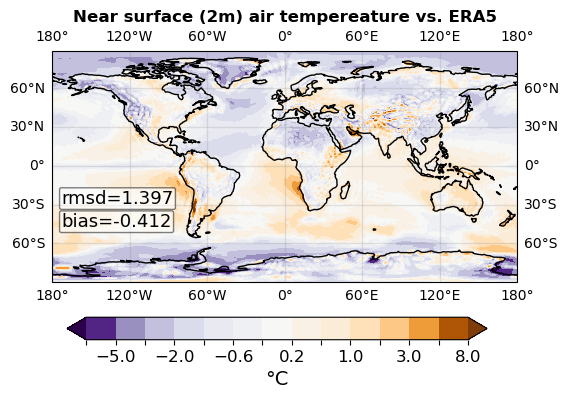

In [3]:


#IMPORTANT I do think that the era5 data is not cuttet to the same years as the model plot
out_path = save_path +  "/figures"
mesh = pf.load_mesh(meshpath)
data = xr.open_dataset(meshpath+'/fesom.mesh.diag.nc')
# parameters cell
input_paths = [model_path]
input_names = [model_name]
saved_filenames=[]
if reanalysis=='ERA5':
    clim='ERA5'
    clim_var='t2m'
    climatology_files = ['T2M_yearmean.nc']
    title='Near surface (2m) air tempereature vs. ERA5'
    climatology_path = observation_path+'/era5/netcdf/'
elif reanalysis=='NCEP2':
    clim='NCEP2'
    clim_var='air'
    climatology_files = ['air.2m.timemean.nc']
    title='Near surface (2m) air tempereature vs. NCEP2'
    climatology_path =  observation_path+'/NCEP2/'

exps=[]
for year in range(model_start,model_end + 1):
    exps.append(year)
        
figsize=(6, 4.5)
ofile = None
res = [360, 180]
var = ['2t']
levels = [-8.0,-5.0,-3.0,-2.0,-1.0,-.6,-.2,.2,.6,1.0,2.0,3.0,5.0,8.0]
contour_outline_thickness = 0

# Set number of columns, in case of multiple variables
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

# Mean Deviation weighted
def md(predictions, targets, wgts):
    output_errors = np.average((predictions - targets), axis=0, weights=wgts)
    return (output_errors).mean()

# Load reanalysis data

reanalysis_path = climatology_path+climatology_files[0]
data_reanalysis_mean = np.squeeze(cdo.timmean(input="-remapcon,r"+str(res[0])+"x"+str(res[1])+" "+str(reanalysis_path),returnArray=clim_var))

# Load model Data
def load_parallel(variable,path):
    data1 = cdo.timmean(input="-remapcon,r"+str(res[0])+"x"+str(res[1])+" "+str(path),returnArray=variable)
    return data1




chunk_size = 10  # Process in chunks of 20

data = OrderedDict()
for exp_path, exp_name in zip(input_paths, input_names):
    data[exp_name] = {}
    for v in var:
        datat = []
        t = []

        # Process in chunks
        for i in range(0, len(exps), chunk_size):
            chunk = exps[i:i + chunk_size]
            chunk_t = []
            
            for exp in chunk:
                path = f"{exp_path}/oifs/atm_remapped_1m_{v}_1m_{exp:04d}-{exp:04d}.nc"
                temporary = dask.delayed(load_parallel)(v, path)
                chunk_t.append(temporary)

            with ProgressBar():
                datat_chunk = dask.compute(*chunk_t, scheduler='threads')
            
            datat.extend(datat_chunk)

        data[exp_name][v] = np.squeeze(datat)

data_model = OrderedDict()
data_model_mean = OrderedDict()



for exp_name in input_names:
    data_model[exp_name] = np.squeeze(data[exp_name][v]) 
    data_model_mean[exp_name] = data_model[exp_name]
    if len(np.shape(data_model_mean[exp_name])) > 2:
        data_model_mean[exp_name] = np.mean(data_model_mean[exp_name],axis=0)
  

print(np.shape(data_model_mean[exp_name]))
print(np.shape(data_reanalysis_mean))

lon = np.arange(0, 360, 1)
lat = np.arange(-90, 90, 1)
data_model_mean[exp_name], lon = add_cyclic_point(data_model_mean[exp_name], coord=lon)


lon = np.arange(0, 360, 1)
lat = np.arange(-90, 90, 1)
data_reanalysis_mean, lon = add_cyclic_point(data_reanalysis_mean, coord=lon)

print(np.shape(data_model_mean[exp_name]))
print(np.shape(data_reanalysis_mean))


coslat = np.cos(np.deg2rad(lat))
wgts = np.squeeze(np.sqrt(coslat)[..., np.newaxis])
rmsdval = sqrt(mean_squared_error(data_model_mean[exp_name],data_reanalysis_mean,sample_weight=wgts))
mdval = md(data_model_mean[exp_name],data_reanalysis_mean,wgts)


import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define figure layout
nrows, ncol = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize,
                         subplot_kw={'projection': ccrs.PlateCarree()})  # Use PlateCarree globally

if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]

# Loop through input names and plot data
for i, exp_name in enumerate(input_names):
    print(exp_name)
    
    ax = axes[i]
    ax.add_feature(cfeature.COASTLINE, zorder=3)

    # Contour plot
    imf = ax.contourf(lon, lat, data_model_mean[exp_name] - data_reanalysis_mean, 
                       cmap=plt.cm.PuOr_r, levels=levels, extend='both',
                       transform=ccrs.PlateCarree(), zorder=1)
    
    line_colors = ['black' for _ in imf.levels]
    imc = ax.contour(lon, lat, data_model_mean[exp_name] - data_reanalysis_mean, 
                     colors=line_colors, levels=levels, linewidths=contour_outline_thickness,
                     transform=ccrs.PlateCarree(), zorder=1)

    ax.set_ylabel('K')
    ax.set_xlabel('Simulation Year')
    ax.set_title(title, fontweight="bold")

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='-')
    gl.xlabels_bottom = False

    # Bias & RMSD Text
    textrsmd = f'rmsd={round(rmsdval, 3)}'
    textbias = f'bias={round(mdval, 3)}'
    props = dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.5)

    ax.text(0.02, 0.4, textrsmd, transform=ax.transAxes, fontsize=13,
            verticalalignment='top', bbox=props, zorder=4)
    ax.text(0.02, 0.3, textbias, transform=ax.transAxes, fontsize=13,
            verticalalignment='top', bbox=props, zorder=4)

# Colorbar
cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
cbar_ax_abs.tick_params(labelsize=12)
cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal', ticks=levels)
cb.set_label(label="°C", size=14)
cb.ax.tick_params(labelsize=12)

# Hide every other tick label
for label in cb.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

# Save figure 
ofile=f'_part8_t2m_vs_era5_air_T'

if ofile is not None:
    plt.savefig(out_path+"/"+tripyrun_name  + ofile, dpi=dpi, bbox_inches='tight')
    saved_filenames.append(out_path + ofile+'.png')

# Mark script as completed
update_status(SCRIPT_NAME, "Completed")



In [4]:
name=out_path+"/"+tripyrun_name  + ofile
name

'/work/ab0995/a270275/runconfig/Results/AWICM3_test031/figures/AWICM3_test018_part8_t2m_vs_era5'